# VC - Entrega Práctica 3
---
 - Luis Martín Pérez
- Andrea Santana López

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

### TAREA 1 - Detector de dinero en monedas

Text(0.5, 1.0, 'Amount of money is: 0 €')

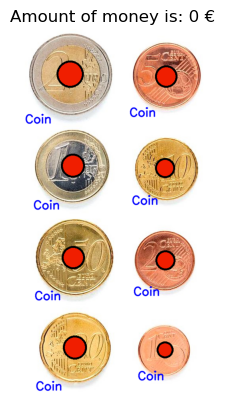

In [4]:
umbral = 200
img = cv2.cvtColor(cv2.imread('./CoinsImages/Monedas.jpg'), cv2.COLOR_BGR2RGB)
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th,img_th = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)


gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Suaviza imagen (elimina altas frecuencias)
pimg = cv2.medianBlur(gris, 7)

circ = cv2.HoughCircles(
        pimg,  # imagen
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=100, # valor del gradiente
        param2=50, # umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
thickness = 2

money_amount = 0
for circle_x, circle_y, circle_radius in circ[0]:
    cv2.circle(img, (int(circle_x), int(circle_y)), int(circle_radius*0.3), (240, 30, 0), -1)
    cv2.circle(img, (int(circle_x), int(circle_y)), int(circle_radius*0.3 + 1), (0, 0, 0), 3)
    img = cv2.putText(img, 'Coin', (int(circle_x - circle_radius*1.1) , int(circle_y + circle_radius*1.2)), font,
                   fontScale, (0, 0, 255), thickness, cv2.LINE_AA)


plt.axis("off")
plt.imshow(img)
plt.title(f'Amount of money is: {money_amount} €')

# Detector Microplasticos

Procesado (Entrenamiento): ./MicroplasticImages/pellet-03-olympus-10-01-2020.jpg. Muestras añadidas: 115
Procesado (Entrenamiento): ./MicroplasticImages/fragment-03-olympus-10-01-2020.jpg. Muestras añadidas: 116
Procesado (Entrenamiento): ./MicroplasticImages/tar-03-olympus-10-01-2020.jpg. Muestras añadidas: 71

Total de muestras extraídas: 302

--- Resultados de Random Forest ---
Precisión del clasificador (Test): 0.4725

--- Matriz de Confusión (Random Forest) ---


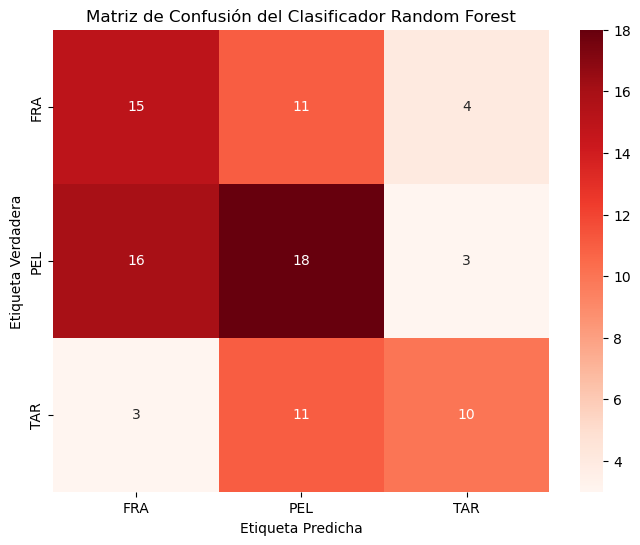


Analizando y dibujando contornos en: ./MicroplasticImages/pellet-03-olympus-10-01-2020.jpg


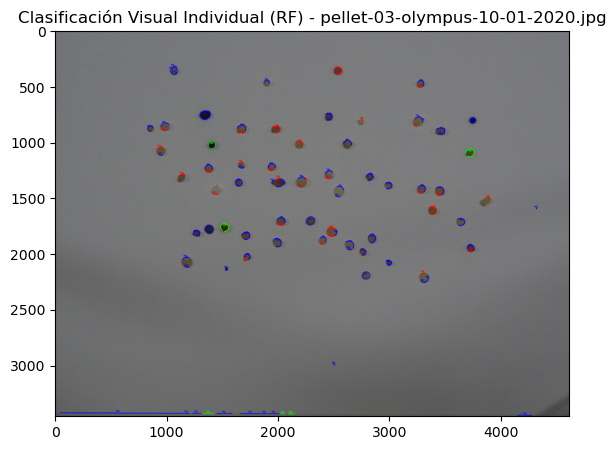


Analizando y dibujando contornos en: ./MicroplasticImages/fragment-03-olympus-10-01-2020.jpg


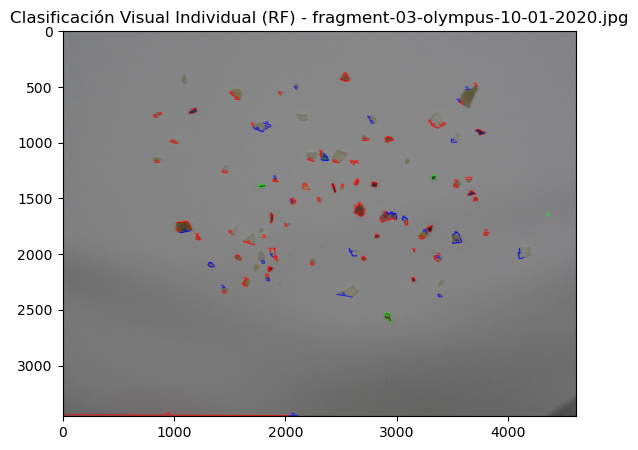


Analizando y dibujando contornos en: ./MicroplasticImages/tar-03-olympus-10-01-2020.jpg


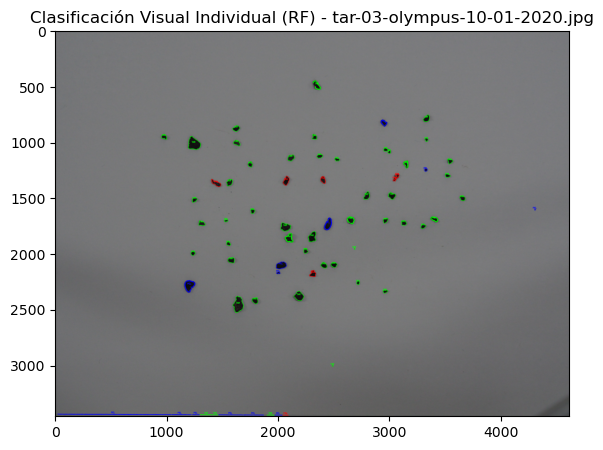

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix

# --- 1. Inicialización y Carga de Imágenes ---
features_list = [] 
labels_list = []
label_map = {"FRA": 0, "PEL": 1, "TAR": 2}
reverse_label_map = {v: k for k, v in label_map.items()}

# Lista de imágenes a procesar con su etiqueta real
images_data = [
    {"path": "./MicroplasticImages/pellet-03-olympus-10-01-2020.jpg", "label": "PEL"},
    {"path": "./MicroplasticImages/fragment-03-olympus-10-01-2020.jpg", "label": "FRA"},
    {"path": "./MicroplasticImages/tar-03-olympus-10-01-2020.jpg", "label": "TAR"},
]

# Colores para dibujar (BGR) - Asignados a la clase predicha
color_map_bgr = {
    0: (0, 0, 255),    # FRA (Rojo)
    1: (255, 0, 0),    # PEL (Azul)
    2: (0, 255, 0)     # TAR (Verde)
}

# --- 2. Función de Extracción de Características para el Entrenamiento ---
def process_image_for_training(image_path, true_label_code):
    
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"Error: No se pudo cargar la imagen en {image_path}")
        return
        
    # --- Detección OPTIMIZADA: Umbral Adaptativo (Más robusto) ---
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    # Umbral Adaptativo Gaussiano
    thresh = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 21, 5) 
    
    
    # Encontrar contornos: clave para objetos individuales
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Iterar sobre contornos y extraer características
    for c in contours:
        area = cv2.contourArea(c)
        # Filtro de área mínima
        if area > 50:
            perimeter = cv2.arcLength(c, True)
            
            # Almacenar la característica y la etiqueta real
            features_list.append([area, perimeter])
            labels_list.append(true_label_code)

    print(f"Procesado (Entrenamiento): {image_path}. Muestras añadidas: {len([c for c in contours if cv2.contourArea(c) > 50])}")

# --- 3. Ejecutar Extracción y Entrenamiento ---
for item in images_data:
    process_image_for_training(item["path"], label_map[item["label"]])

# Preparación de Datos y Entrenamiento
X = pd.DataFrame(features_list, columns=['Area', 'Perimetro'])
y = pd.Series(labels_list)
print(f"\nTotal de muestras extraídas: {len(X)}")

# División y Entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluación
y_pred = rf_model.predict(X_test)
print('\n--- Resultados de Random Forest ---')
print(f"Precisión del clasificador (Test): {accuracy_score(y_test, y_pred):.4f}")

# --- MATRIZ DE CONFUSIÓN ---
print('\n--- Matriz de Confusión (Random Forest) ---')
cm = confusion_matrix(y_test, y_pred)
class_names = list(label_map.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', # Cambiando el color a 'Reds' para distinguirlo
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión del Clasificador Random Forest')
plt.show()
# ----------------------------

# --- 4. Función de Predicción y Dibujo (Contorno Individual) ---
def predict_and_draw_contours(image_path, classifier, features_cols):
    """Carga, segmenta, predice la clase de CADA contorno y lo dibuja."""
    
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        return
        
    # --- Detección: Umbral Adaptativo (Misma lógica que el entrenamiento) ---
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    # Umbral Adaptativo Gaussiano
    thresh = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 21, 5) 
    
    # Cierre para rellenar pequeños huecos
    kernel = np.ones((3,3),np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    # ---------------------------------------------------------------------
    
    # Encontrar contornos INDIVIDUALES
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    img_with_predictions = img_bgr.copy()
    
    print(f"\nAnalizando y dibujando contornos en: {image_path}")

    # Iterar sobre CADA contorno, predecir y dibujar
    for c in contours:
        area = cv2.contourArea(c)
        
        # Filtro de área
        if area > 50: 
            perimeter = cv2.arcLength(c, True)
            
            # Crear el dato para la predicción
            new_feature = pd.DataFrame([[area, perimeter]], columns=features_cols)
            
            # Predecir la clase
            # Usa el clasificador pasado como argumento (rf_model)
            predicted_label_code = classifier.predict(new_feature)[0] 
            predicted_class = reverse_label_map[predicted_label_code]
            color = color_map_bgr.get(predicted_label_code, (255, 255, 255))
            
            # --- DIBUJAR CONTORNO Y CLASIFICACIÓN ---
            cv2.drawContours(img_with_predictions, [c], -1, color, 3)
            
            # Poner el texto de la clase predicha cerca del objeto
            M = cv2.moments(c)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                cv2.putText(img_with_predictions, predicted_class, (cX - 20, cY - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
                            
    # 5. Mostrar el resultado
    plt.figure(figsize=(10, 5))
    plt.title(f"Clasificación Visual Individual (RF) - {image_path.split('/')[-1]}")
    plt.imshow(cv2.cvtColor(img_with_predictions, cv2.COLOR_BGR2RGB))
    plt.show()

# --- 5. Ejecutar la Predicción y Visualización para las 3 Imágenes ---

for item in images_data:
    # Usar el nuevo modelo Random Forest
    predict_and_draw_contours(item["path"], rf_model, X.columns)